In [2]:
setwd("/public/workspace202011/rice_encode/works/")

Using bed as id variables



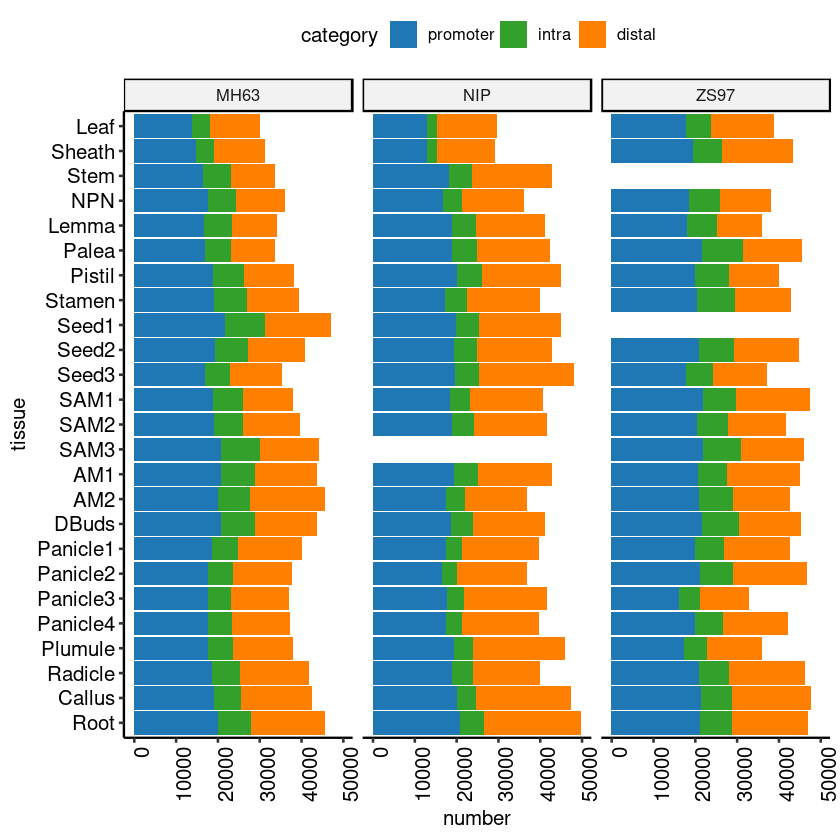

In [5]:
options(stringsAsFactors=FALSE)
library(ggplot2)
library(ggpubr)
library(pals)
library(dplyr)
library(pheatmap)
library(ggthemes)
library(RColorBrewer)
library(scales)

gcols <- c(ZH97="#00AFBB", MH63="#E7B800", NIP="#FC4E07", Public="#999999")
meta <- read.delim("final.meta", row.names = 7, quote = "", header = F)
group <- read.delim("group.meta", row.names = 1, header = F)
ccols <- c(promoter="#1F78B4",intra="#33A02C",distal="#FF7F00")
peaks <- read.delim("peak.annotation.txt") %>% reshape::melt() %>%
  rename(sample="bed", category="variable", number="value") %>%
  mutate(plant=gsub("_.*","",sample), tissue=gsub("[^_]*_","",sample)) %>%
  mutate(tissue=factor(tissue, levels = rownames(group))) %>%
  mutate(category=factor(category, levels = rev(names(ccols))))

c1 <- tableau_color_pal("Classic 20")(20)
c2 <- tableau_color_pal("Classic Green-Orange 12")(12)

tcols <- c(stepped(24)[c(9,11,13,15)], stepped2(20)[c(9,11,13,15,17,19)], stepped(24)[1], 
           stepped3(20)[c(5:7)], stepped(24)[c(16:18)])
tcols <- c(c1[5:6],c2[1:2],c1[8:14],c1[c(3:4,7)],c2[c(3:4,7)],c1[c(1:2,19:20)],c2[10:12],c1[15])
names(tcols) <- rownames(group)


f1b <- peaks %>% mutate(tissue=factor(tissue, levels = rev(rownames(group)))) %>% 
  filter(category!="all") %>% 
  ggplot(aes(x=number, y=tissue, fill=category)) + 
  geom_bar(stat = "identity") + facet_wrap(~ plant, ncol=3) +
  scale_fill_manual(values = ccols) +
  theme_pubr() + theme(axis.text.x=element_text(angle=90, hjust=1))
f1b

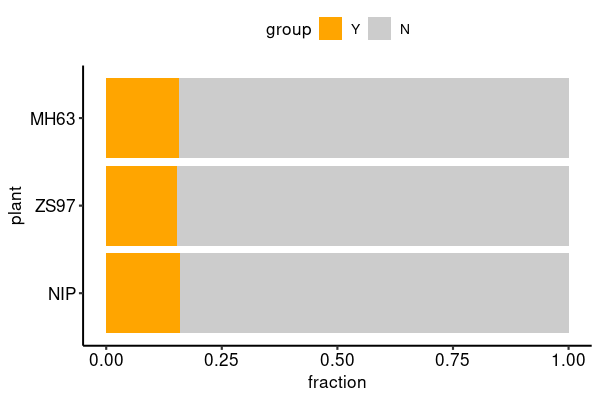

In [11]:
pss <- read.delim("peak.size", row.names = 1, header = F)

data <- do.call('rbind',
  lapply(rownames(pss), function(x){
  data <- read.delim(sprintf("%s.coverage.stat",x), header = F)[,2:3]
  colnames(data) <- c("category", "count")
  data <- rbind(data.frame(category=0, count=pss[x,2]-sum(data[,2])), data)
  data$x <- 4 - which(rownames(pss)==x)
  data$plant <- x 
  # Compute percentages
  data$fraction <- data$count / sum(data$count)
  # Compute the cumulative percentages (top of each rectangle)
  data$ymax <- cumsum(data$fraction)
  # Compute the bottom of each rectangle
  data$ymin <- c(0, head(data$ymax, n=-1))
  data 
}))

data <- data %>% mutate(plant=factor(plant, levels = rownames(pss))) %>% 
  mutate(group=ifelse(category=="0","N", "Y"))
# Make the plot
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 100)
f1c2 <- data %>% 
  ggplot(aes(fill=group, x=fraction, y=plant)) + 
  geom_bar(position="fill", stat="identity") + 
  scale_fill_manual(values = c(Y="orange", N="grey80")) +
  theme_pubr()
f1c2

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 2641 rows containing non-finite values (stat_density).”


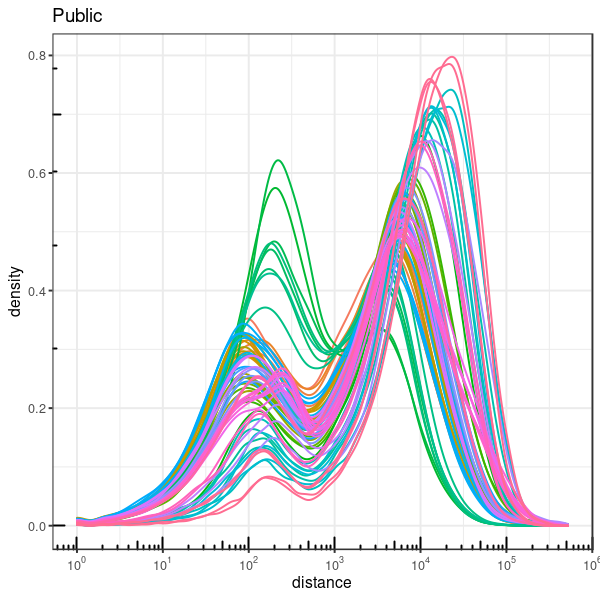

In [16]:
plsts1d <- lapply(c("NIP","MH63","ZS97"), function(x){
  distd <- read.delim(sprintf("%s.peak2tss.out", x), header = F)
  colnames(distd) <- c("tissue", 'distance')
  distd$tissue <- gsub("[^_]*_", "", distd$tissue)
  ## distd$logdist <- log10(distd$distance + 1)
  distd %>% ggplot(aes(x=distance, color=tissue)) +
    geom_density() + scale_color_manual(values = tcols) +
    scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
                  labels = trans_format("log10", math_format(10^.x))) +
    annotation_logticks() + theme_bw() + Seurat::NoLegend() +
    ggtitle(x)
})
    
distd <- read.delim("public.peak2tss.out", header = F)
colnames(distd) <- c("tissue", 'distance')
distd$tissue <- gsub("[^_]*_", "", distd$tissue)
f1d1s <- distd %>% ggplot(aes(x=distance, color=tissue)) +
  geom_density() + ggtitle("Public") +
  scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
                                 labels = trans_format("log10", math_format(10^.x))) +
  annotation_logticks() + theme_bw() + Seurat::NoLegend()

options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
f1d1s

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 5960 rows containing non-finite values (stat_density).”


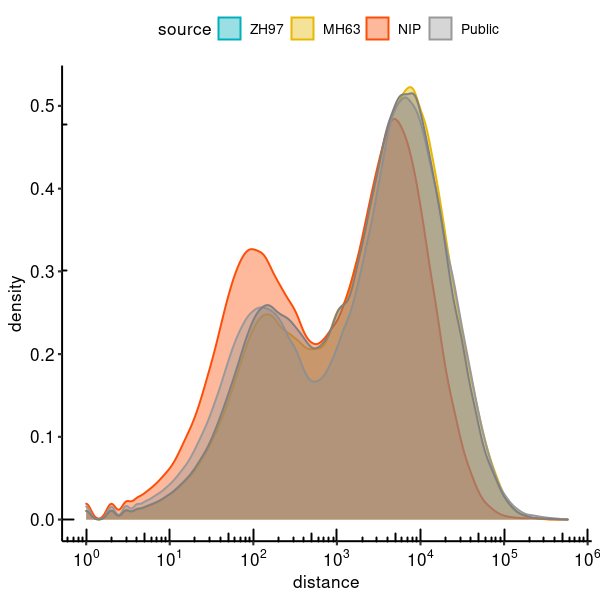

In [17]:
f1dd <- do.call("rbind", lapply(c("NIP","MH63","ZS97"), function(x){
  distd <- read.delim(sprintf("%s.peak2tss.out", x), header = F)
  colnames(distd) <- c("tissue", 'distance')
  distd$source <- x
  distd
}))
distd <- read.delim("public.peak2tss.out", header = F)
colnames(distd) <- c("tissue", 'distance')
distd$source <- 'Public'
f1dd <- rbind(f1dd, distd)

f1d <- f1dd %>% ggplot(aes(x=distance, fill=source, color=source)) +
  geom_density(alpha=0.4)  +
  scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  scale_color_manual(values = gcols) +
  scale_fill_manual(values = gcols) +
  annotation_logticks() + theme_pubr()
f1d

In [ ]:
peak_num_del <- read.table("/public/workspace202011/encode/zhutao/analysis/Figure/Fig1/NIP_peak_num_order.txt")
#peak_num_del$sample <- "NIP"
peak_num_del <- peak_num_del[,c(2,3,4)]
library(data.table)
long <- melt(setDT(peak_num_del), id.vars = c("V2"), variable.name = "V3")
long$sample <- c(rep("NIP",25),rep("MH63",25))
peak_num_del <- read.table("/public/workspace202011/encode/zhutao/analysis/Figure/Fig1/NIP_MH_ZS_peak_deletion_num.txt",sep='|')
colnames(peak_num_del) <- c("Tissue","Number")
peak_num_del$Sample <- c(rep("NIP",25),rep("MH63",26),rep("ZS97",25))
peak_num_del1 <- peak_num_del[peak_num_del$Sample=="NIP",]
peak_num_del1$Number <- abs(peak_num_del1$Number - 95697)
peak_num_del1 <- peak_num_del1[peak_num_del1$Tissue!="All_peaks",]
peak_num_del2 <- peak_num_del[peak_num_del$Sample=="MH63",]
peak_num_del2$Number <- abs(peak_num_del2$Number - 95697)
peak_num_del2 <- peak_num_del2[peak_num_del2$Tissue!="All_peaks",]
peak_num_del3 <- peak_num_del[peak_num_del$Sample=="ZS97",]
peak_num_del3$Number <- abs(peak_num_del3$Number - 95697)
peak_num_del3 <- peak_num_del3[peak_num_del3$Tissue!="All_peaks",]
res <- rbind(peak_num_del1,peak_num_del2,peak_num_del3)
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 100)
library(ggplot2)
library(ggpubr)
p7 <- ggplot(res, aes(x=factor(Tissue,levels=peak_num_del2$Tissue), y=Number,color=Sample,group=Sample)) + 
  geom_point(size=2)  +  geom_smooth(se=FALSE)+scale_color_manual(values = c("NIP"="#FC4E07","MH63"="#E7B800","ZS97"="#00AFBB"))+
  theme_pubr()+labs(y = "Number of peaks (x 1000)",x='')+theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+theme(legend.title = element_blank())
p7

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



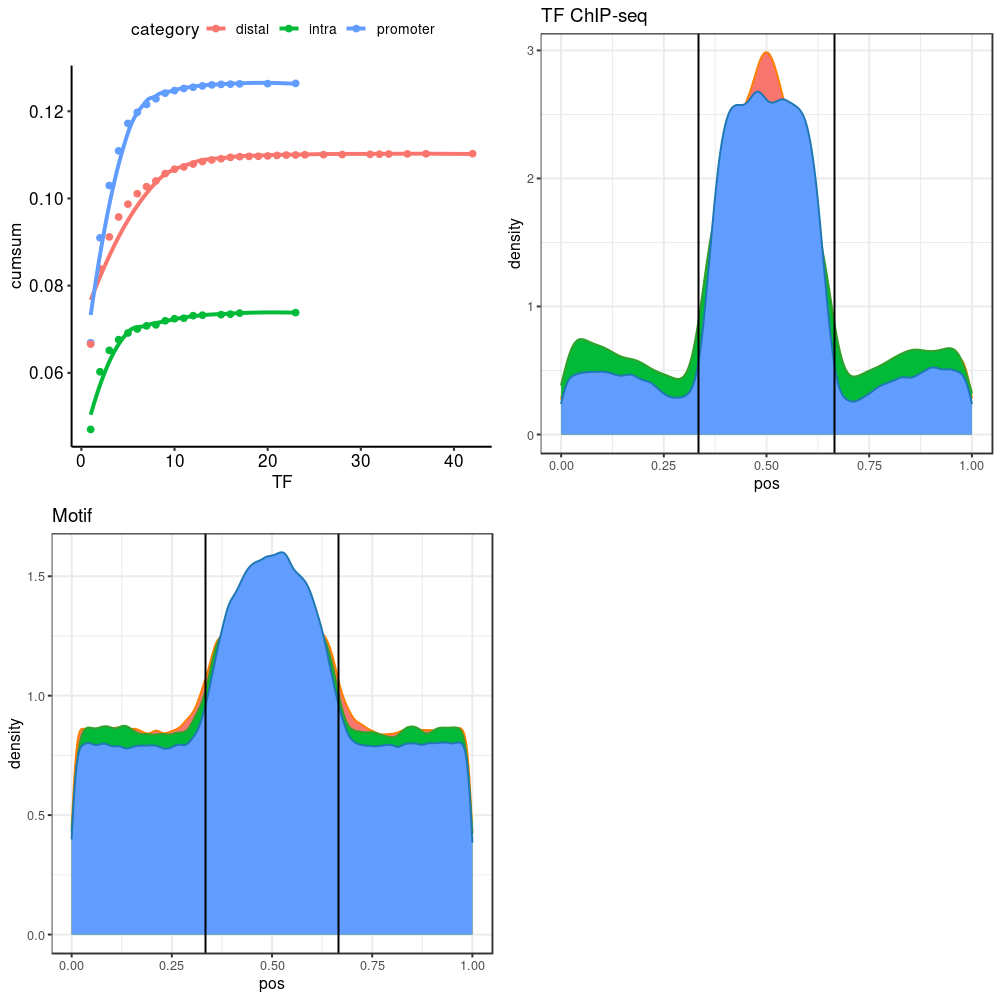

In [26]:
targets <- read.delim("NIP.merged.closest.genes", header = F)
rownames(targets) <- sprintf("%s:%s-%s", targets[,1], targets[,2], targets[,3])
tarstat <- table(targets$V5, targets$V4)
tx <- rownames(tarstat)[tarstat[,'distal'] > 0 & (tarstat[,'intra'] > 0 | tarstat[, 'promoter'] > 0)]  
targets <- targets %>% filter(V5 %in% tx)
f1ed <- do.call('rbind', lapply(names(ccols), function(x){
  o <- read.delim(sprintf("NIP.merged.%s.count",x), header = F)
  rownames(o) <- sprintf("%s:%s-%s", o[,1], o[,2], o[,3]) 
  o <- o[rownames(o) %in% rownames(targets),]
  o <- o[,4:5]
  ## o <- o %>% filter(V5>0) 
  s <- cumsum(table(o %>% filter(V5>0) %>% pull(V5)))/nrow(o)
  data.frame(category=x, TF=as.numeric(names(s)), cumsum=s)
}))

f1e1 <- f1ed %>% ggplot(aes(x=TF, y=cumsum, color=category)) + 
  geom_point() + geom_smooth(se=FALSE) + 
  scale_fill_manual(values = ccols) +
  theme_pubr()

TFdist <- read.delim("NIP.merged.TFdist", header = F)
colnames(TFdist) <- c('category', 'pos')
f1e2 <- TFdist %>% ggplot(aes(x=pos, color=category, fill=category)) +
  geom_density() + scale_color_manual(values = ccols) +
  geom_vline(xintercept=1:2/3) + 
  theme_bw() + Seurat::NoLegend() +ggtitle("TF ChIP-seq")

Motifdist <- read.delim("NIP.merged.TFmotif", header = F)
colnames(Motifdist) <- c('category', 'pos')
f1e3 <- Motifdist %>% ggplot(aes(x=pos, color=category, fill=category)) +
  geom_density() + scale_color_manual(values = ccols) +
  geom_vline(xintercept=1:2/3) + 
  theme_bw() + Seurat::NoLegend()+ggtitle("Motif")

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
ggarrange(f1e1, f1e2, f1e3, nrow = 2, ncol = 2)

In [27]:
dat <- read.delim("quant/merged.matrix", header = F)
colnames(dat) <- scan('quant/merged.header', what=character())
rownames(dat) <- sprintf("%s:%s-%s", dat[,1], dat[,2], dat[,3])
dat <- dat[,-(1:3)] 
dat <- dat[rowSums(dat) > 0, ]

library(preprocessCore)
quant <- normalize.quantiles(as.matrix(dat))
rownames(quant) <- rownames(dat) 
colnames(quant) <- colnames(dat) 
rm(dat)

library(Rtsne)
set.seed(2021) # Set a seed if you want reproducible results
tsne_out <- Rtsne(t(as.matrix(quant)), dims = 3) # Run TSNE

qmeta <- meta[paste0(colnames(quant), "_R1"), ]
pchs <- as.integer(factor(qmeta[,3]))+20
labs <- sprintf("%s/%s", qmeta[,2], qmeta[,6])

pltd <- tsne_out$Y
colnames(pltd) <- sprintf("tSNE%s", 1:3)
rownames(pltd) <- colnames(quant)
pltd <- cbind(pltd, qmeta)

library(ggrepel)
fih1 <- ggplot(pltd, aes(x=tSNE1, y=tSNE2, color=V2, label = V2)) +
  scale_color_manual(values = tcols) + 
  geom_point(aes(color=V2, shape=V3)) + geom_text_repel() +
  theme_classic(base_size = 12) + Seurat::NoLegend()
fih2 <- ggplot(pltd, aes(x=tSNE2, y=tSNE3, color=V2, label = V2)) +
  scale_color_manual(values = tcols) + 
  geom_point(aes(color=V2, shape=V3)) + geom_text_repel() +
  theme_classic(base_size = 12) + Seurat::NoLegend()


Warning message:
“ggrepel: 122 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 128 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


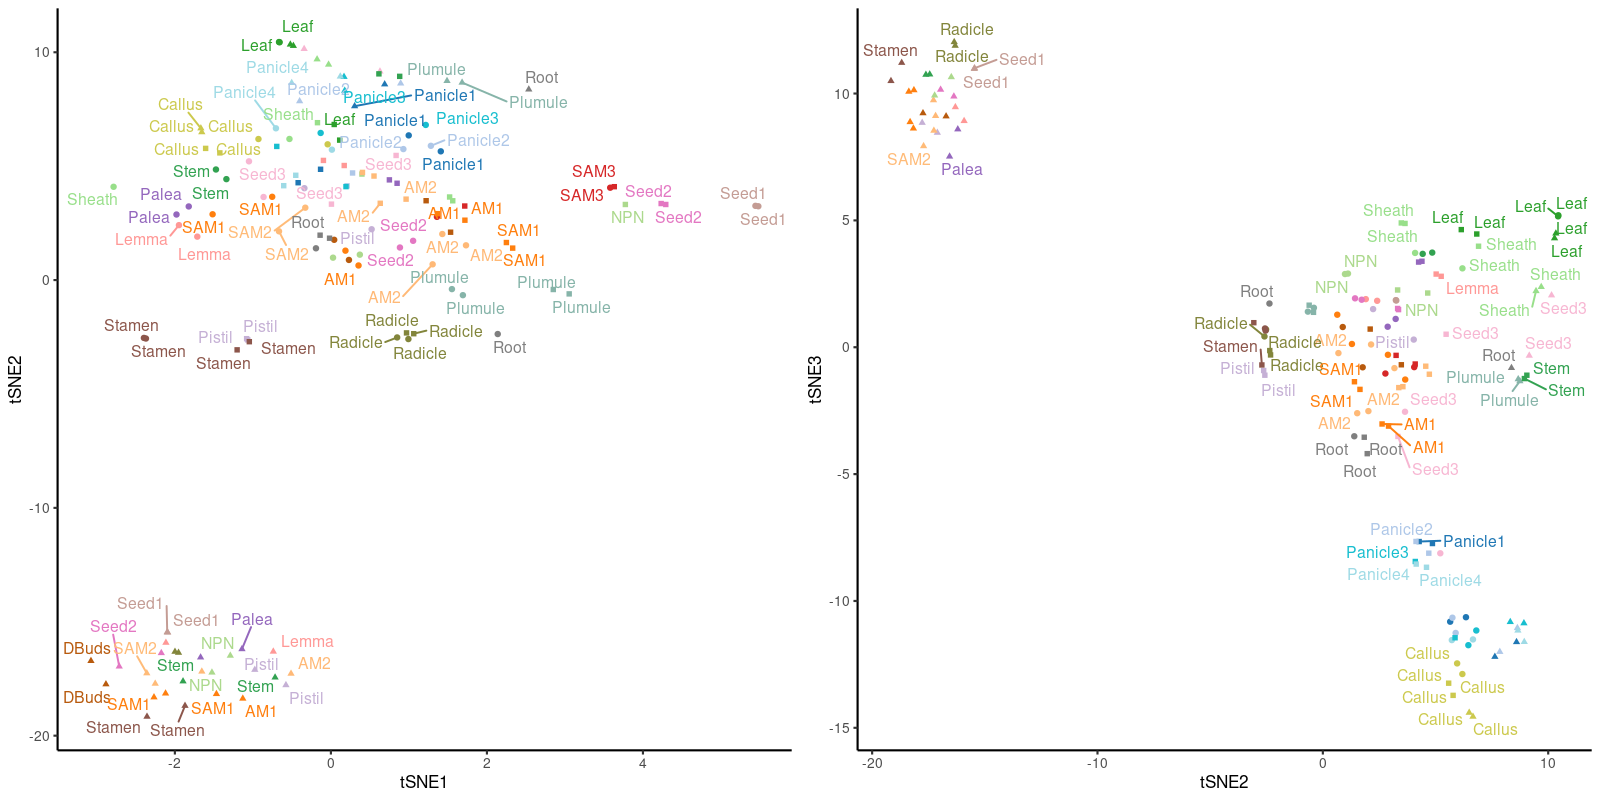

In [32]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 100)
ggarrange(fih1,fih2, nrow = 1, ncol = 2)

`summarise()` has grouped output by 'plant'. You can override using the `.groups` argument.



plant,group,median(H_specificity)
<chr>,<chr>,<dbl>
MH63,distal,0.02646673
MH63,intra,0.02308790
MH63,promoter,0.01532166
NIP,distal,0.02476459
NIP,intra,0.02165670
NIP,promoter,0.01338494
ZS97,distal,0.02640861
ZS97,intra,0.02233735
ZS97,promoter,0.01477153


`summarise()` has grouped output by 'tissue'. You can override using the `.groups` argument.



tissue,group,median(H_specificity)
<chr>,<chr>,<dbl>
AM1,distal,0.03386508
AM1,intra,0.02351634
AM1,promoter,0.01597608
AM2,distal,0.03262913
AM2,intra,0.02599945


`summarise()` has grouped output by 'tissue'. You can override using the `.groups` argument.

Warning message:
“Computation failed in `stat_signif()`:
missing value where TRUE/FALSE needed”


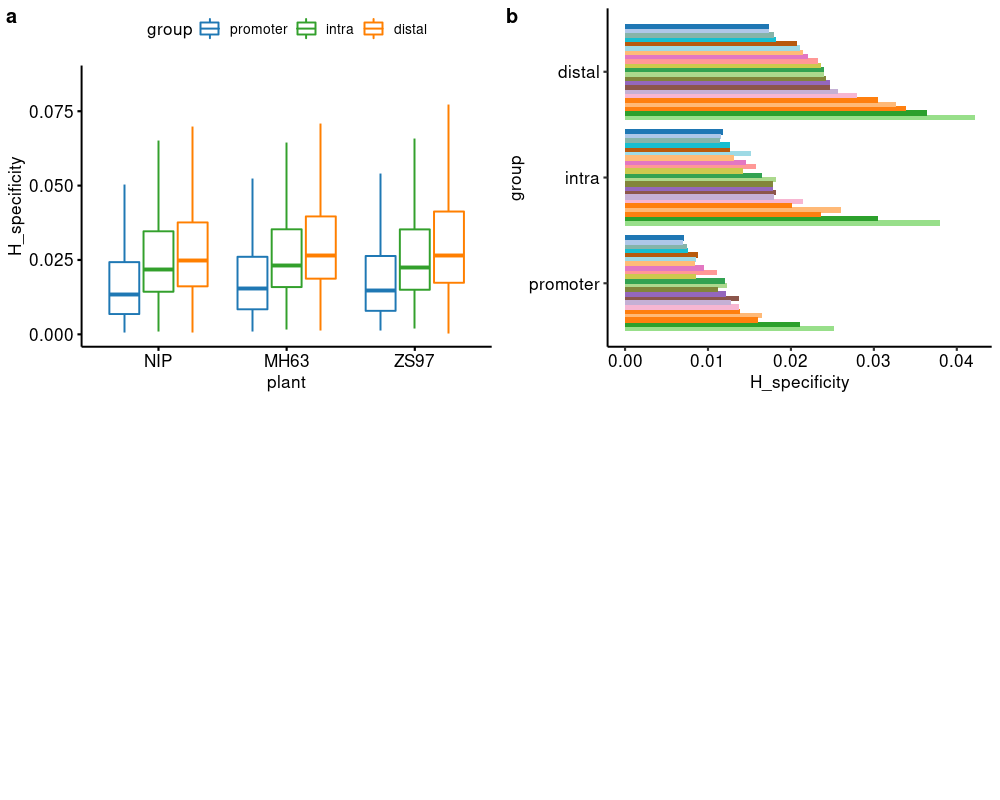

In [35]:
ptype <- read.delim("quant/merged.type", header = F)
rownames(ptype) <- sprintf("%s:%s-%s", ptype[,1], ptype[,2], ptype[,3])
category <- ptype[rownames(quant),]



library(philentropy)
Hindx <- NULL 
for(x in c("NIP","MH63","ZS97")){
  dat <- quant[, grep(x, colnames(quant))]
  n_tissue <- ncol(dat)
  entropy <- apply(dat, 1, function(x){H(x/sum(x))})
  ## bring to normalized scale
  H_specificity <- 1 - entropy / log2(n_tissue)
  Hindx <- rbind(Hindx, data.frame(plant=x, peak=names(H_specificity), 
                                   group=category[names(H_specificity),'V5'], 
                                   H_specificity))
}

Hindx %>% group_by(plant, group) %>% summarize(median(H_specificity))

Hindx2 <- NULL 
for(x in unique(meta$V2)){
  dat <- quant[, gsub("_R1","",rownames(meta[meta$V2==x, ]))]
  n_tissue <- ncol(dat)
  if(n_tissue > 5){
    entropy <- apply(dat, 1, function(x){H(x/sum(x))})
    ## bring to normalized scale
    H_specificity <- 1 - entropy / log2(n_tissue)
    Hindx2 <- rbind(Hindx2, data.frame(tissue=x, peak=names(H_specificity), 
                                       group=category[names(H_specificity),'V5'], 
                                       H_specificity))
  }
}

Hindx2 %>% group_by(tissue, group) %>% summarize(median(H_specificity))%>%head(n=5)


if(F){
  ## divergence
  library(parallel)
  library(MASS)
  library(foreach)
  library(doParallel)
  numCores <- 20 ## detectCores()
  registerDoParallel(numCores)
  JS <- foreach (i=1:nrow(quant), .combine=c) %dopar% {
    ones <- diag(1, n_tissue, n_tissue)
    xjs <- foreach (j=1:nrow(ones), .combine=c) %dopar% {
      x <- rbind(as.numeric(quant[i,]), ones[j,])
      suppressMessages(JSD(x, est.prob="empirical"))
    }
    max(xjs)
  }
  JS_specificity <- 1 - sqrt(JS)## /log2(n_tissue)
}


library(cowplot)
library(ggpubr)
Hindx$group <- factor(Hindx$group, levels = c("promoter","intra","distal"))
p1 <- ggboxplot(Hindx, "plant", "H_specificity", outlier.shape = NA, color = "group", palette = ccols)  +
  coord_cartesian(ylim = quantile(Hindx$H_specificity, c(0, 0.97))) +
  stat_compare_means(comparisons=list(c("distal", "promoter"))) 
Hindx2$group <- factor(Hindx2$group, levels = c("promoter","intra","distal"))
pltd <- Hindx2 %>% group_by(tissue, group) %>% 
  summarize(H_specificity=median(H_specificity)) %>%
  arrange(desc(group), desc(H_specificity))
pltd$tissue <- factor(pltd$tissue, levels=unique(pltd$tissue))
p2 <- pltd %>%
  ggplot(aes(y=group, x=H_specificity, fill=tissue)) +
  geom_bar(stat = "identity", position=position_dodge()) + 
  scale_fill_manual(values = tcols) +
  theme_pubr() + Seurat::NoLegend()
f1i1 <- plot_grid(p1, p2, NULL, ncol=2, labels=letters[1:2])
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)
f1i1

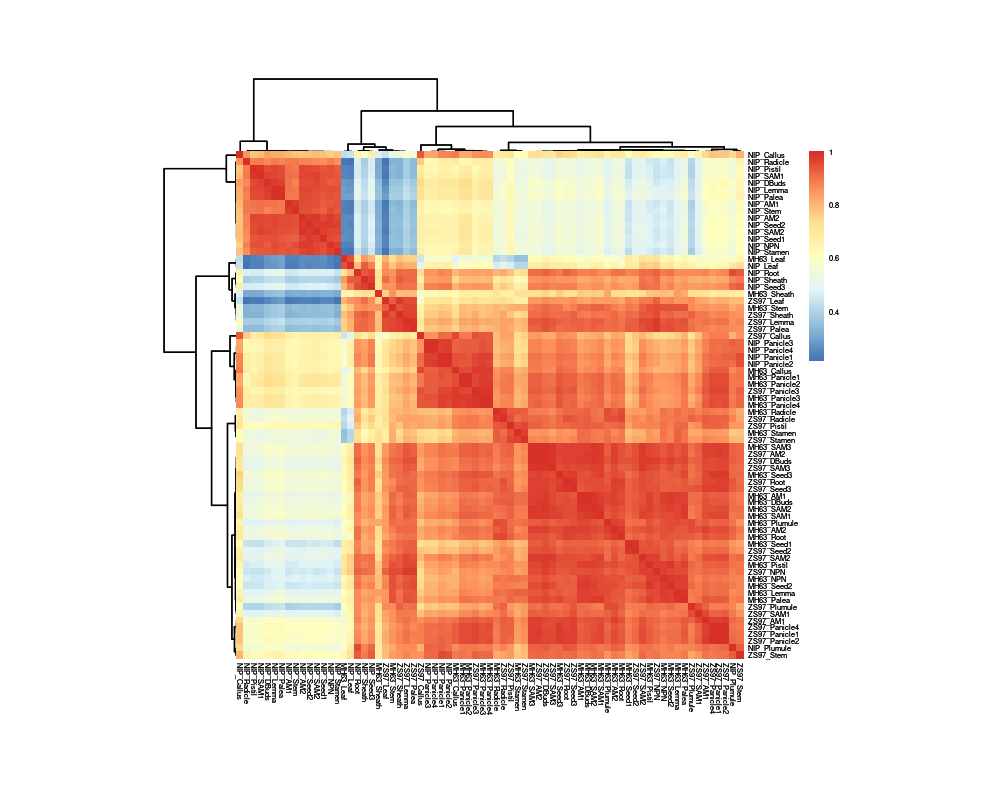

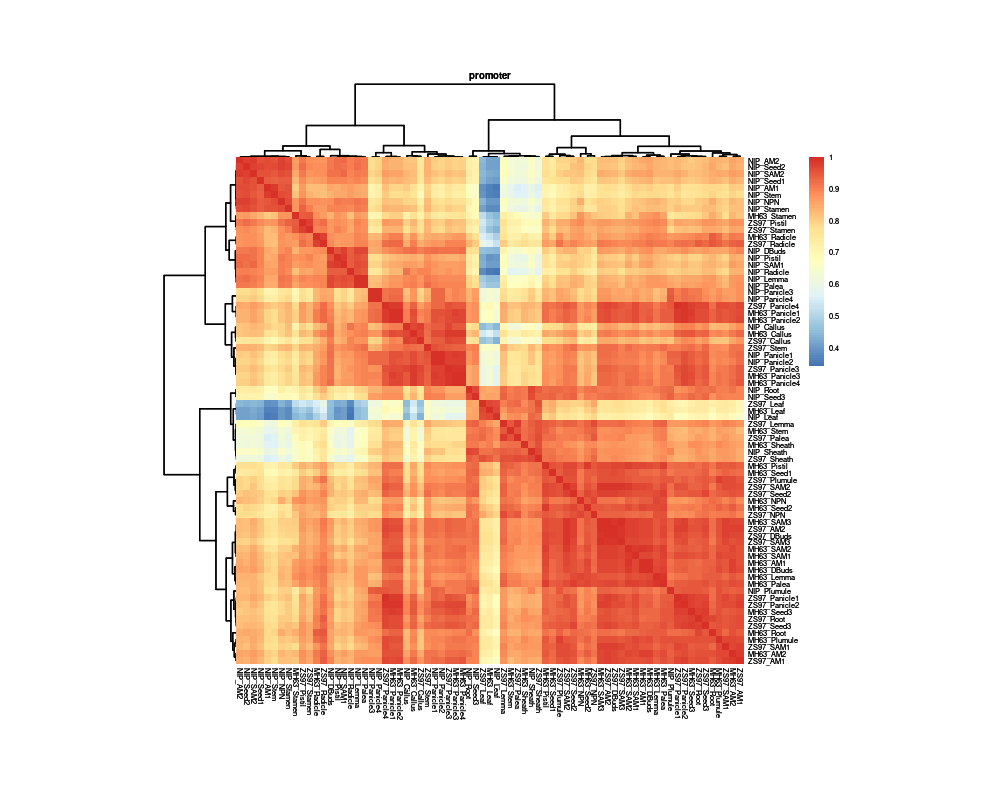

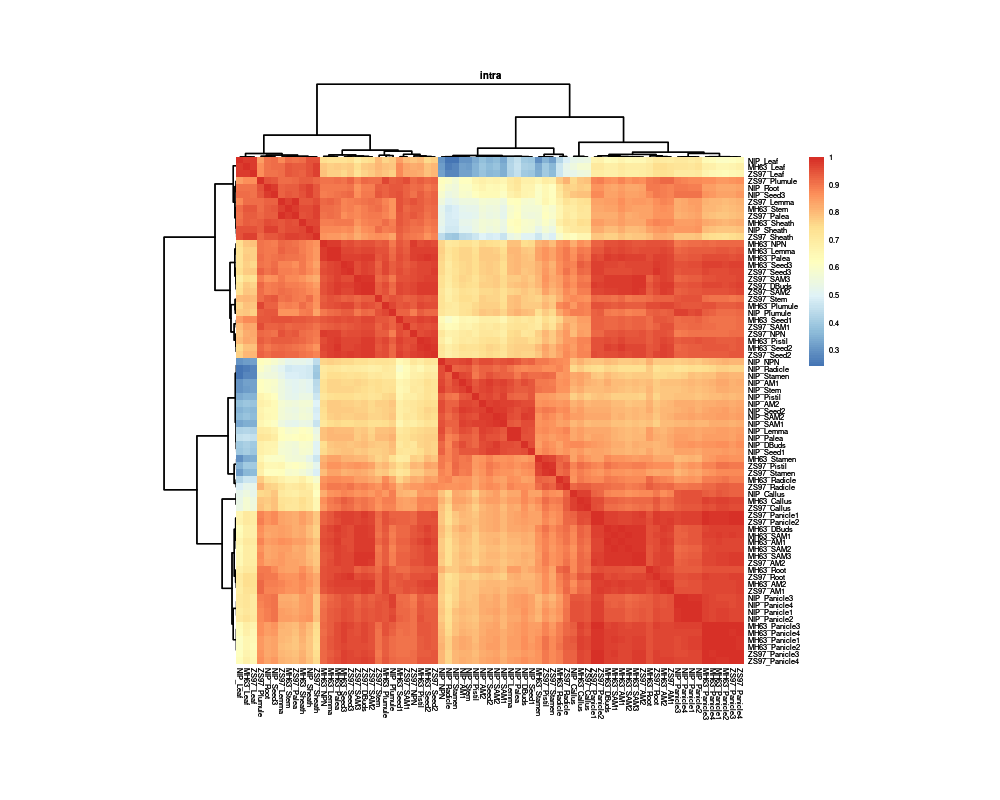

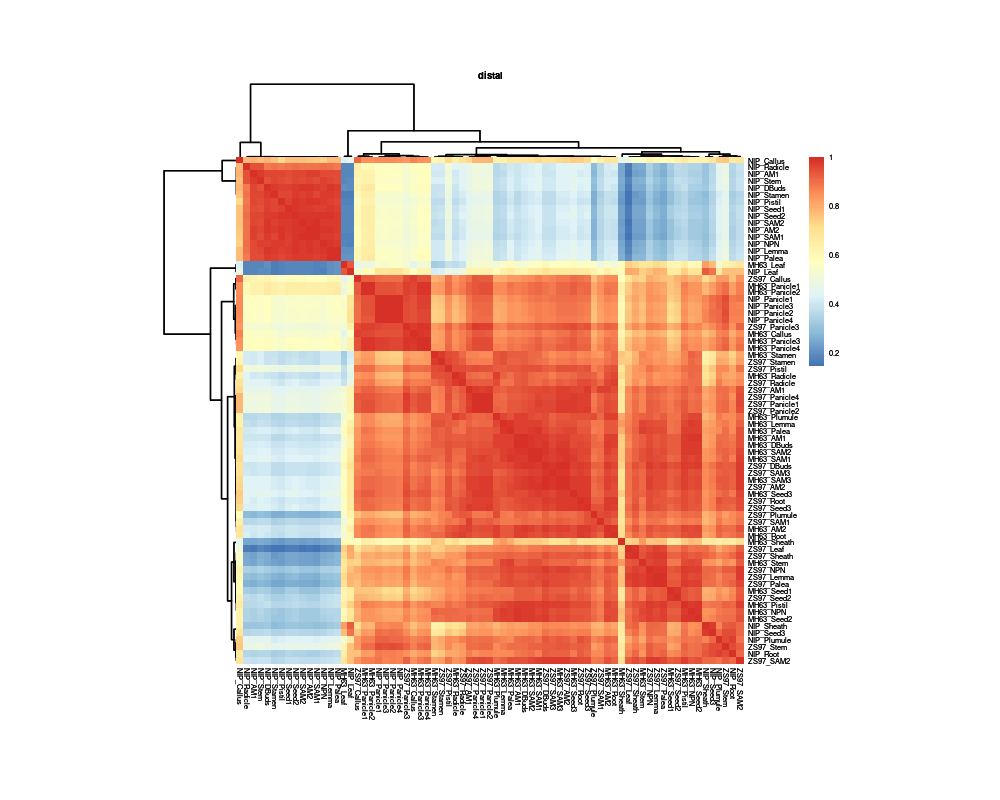

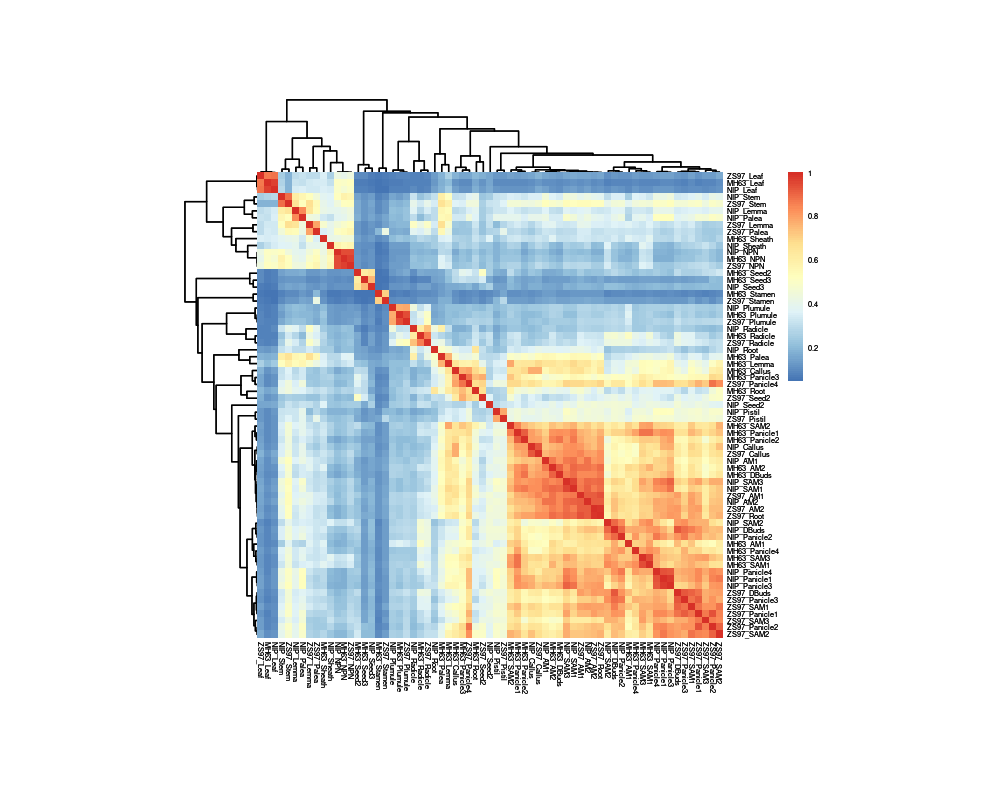

In [39]:
print(pheatmap(cor(ATACseq[,-c(1:5)]), cellwidth = 5, cellheight = 5, 
               clustering_distance_rows="correlation", clustering_distance_cols="correlation",
               border_color = NA, fontsize = 5))
for(i in c("promoter", "intra", "distal")){
  print(pheatmap(cor(ATACseq[ATACseq$Category==i,-c(1:5)]), cellwidth = 5, cellheight = 5, 
                 clustering_distance_rows="correlation", clustering_distance_cols="correlation",
                 border_color = NA, fontsize = 5, main = i))
}
#dev.off()

RNAseq <- readRDS('RNAseq.rds')
RNAseq <- RNAseq[rowSums(RNAseq)>0,]
#pdf("RNAseq.pdf", width = 8.27, height = 8.27)
print(pheatmap(cor(RNAseq), cellwidth = 5, cellheight = 5, 
               clustering_distance_rows="correlation", clustering_distance_cols="correlation",
               border_color = NA, fontsize = 5))
#dev.off()